In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import cycle

# ** Performance Analysis for Particular Agent**

In [21]:
fname_rand = "2048-AI/logs/RandomAgentTrials1000.csv"
fname_max_corner = "2048-AI/logs/MaxTileCornerExpectimaxAgentDepth2Trials100.csv"

fname_ascend_rows = "2048-AI/logs/AscendingRowsExpectimaxAgentDepth2Trials100.csv"

fname_max_tile_row = "2048-AI/logs/FullMaxRowExpectimaxDepth2Trials34.csv"

fname_weight_heur = "2048-AI/logs/WeightedExpectimaxAgentDepth2Trials11.csv"

fname_monte = "2048-AI/logs/MonteCarloRolloutTrials10.csv"

fname_num_empt = "2048-AI/logs/NumEmptyExpectimaxAgentDepth2Trials100.csv"

fname_max_score = "2048-AI/logs/MaxScoreExpectimaxAgentDepth2Trials10.csv"

fname_snake = "2048-AI/logs/SnakeDepth2Trials10.csv"

fname_max_tile = "2048-AI/logs/MaxTileExpectimaxDepth2Trials10.csv"

fname_tile_diff = "2048-AI/logs/TileDiffDepth2Trials10.csv"

In [146]:
fname = fname_rand
data = pd.read_csv(fname)
identify = " Random"
n = 4

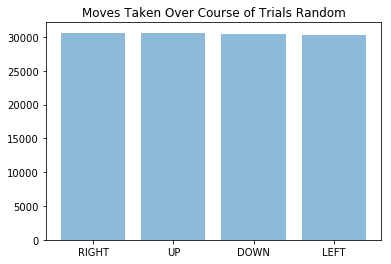

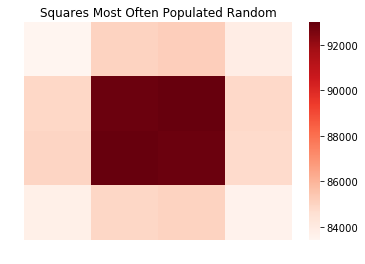

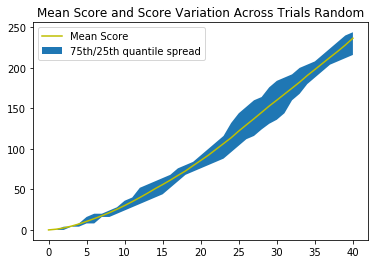

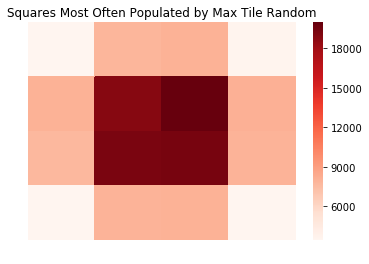

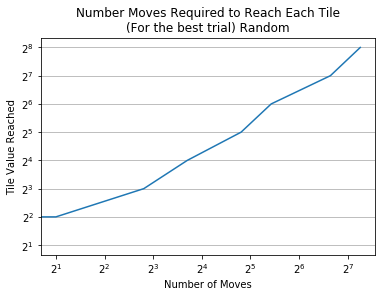

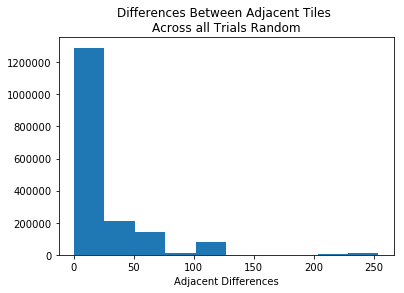

In [147]:
num_moves = data.loc[:, "Move"].value_counts()

#### BAR CHART TO OBSERVE MOST COMMON MOVES ####
#
x = range(len(num_moves))
plt.title("Moves Taken Over Course of Trials" + identify)
plt.bar(x, num_moves.values, align = 'center', alpha = 0.5)
plt.xticks(x, num_moves.axes[0])
plt.savefig("2048_moves_barchart" + identify)
plt.show()

#### HEATMAP TO OBSERVE TILE LOCATION CHANGES OVER TIME ####
#
which_squares_occupied = data.loc[:, "Val0":"Val15"] != 0
sum_tiles_is_occupied = np.array(which_squares_occupied.sum()).reshape((n, n))

# In case seaborn doesn't work, this plots the same thing
# plt.pcolormesh(np.flip(a, 0), cmap = "Blues")
# plt.show()

# annot = sum_tiles_is_occupied for annotations
sns.heatmap(
    sum_tiles_is_occupied, 
    cmap = "Reds"
)
plt.title("Squares Most Often Populated" + identify)
plt.axis("off")
plt.savefig("2048_tile_heatmap" + identify)
plt.show()

#### PLOT TO OBSERVE MEAN SCORE AND SPREAD ACROSS TRIALS ####
#
score_trial_pair_data = data.loc[:, ["Score", "Trial"]]
trials = np.unique(score_trial_pair_data.Trial)

# List to contain each trial's score series 
scores_lst_by_trial = []
for trial_num in trials:
    indices_of_trial = score_trial_pair_data["Trial"] == trial_num
    trial_data = score_trial_pair_data.loc[indices_of_trial].reset_index(drop = True)
    scores_lst_by_trial.append(trial_data.loc[:, "Score"])

# Truncate each score series to the shortest scores series across
# the trials (by dropping the na's from the entire dataframe)
scores_by_trial = pd.DataFrame(scores_lst_by_trial).dropna(axis = 1)

# Get mean score across all trials for each move
# Get 75th and 25th percentiles across all trials for each move
# to observe spread
mean_line = scores_by_trial.mean()
percentile_75th = scores_by_trial.quantile(0.75)
percentile_25th = scores_by_trial.quantile(0.25)

# Plot spread and mean
x = range(len(mean_line))
plt.title("Mean Score and Score Variation Across Trials" + identify)
plt.plot(x, mean_line, color = 'y', label = "Mean Score")
plt.fill_between(
    x, 
    percentile_75th, 
    percentile_25th, 
    label = "75th/25th quantile spread"
)
plt.legend()
plt.savefig("2048_score_and_spread" + identify)
plt.show()

#### HEATMAP TO OBSERVE MOST COMMON LOCATION OF MAXTILE ####
tiles = data.loc[:, "Val0":"Val15"].copy()

# True for entry within particular row if that entry contains max tile value
# at that point in the game, otherwise false
is_max_tile_each_row = tiles.apply(
    lambda row: row == data.loc[:, "Val0":"Val15"].max(axis = 1)
)

frequency_max_tile = np.array(is_max_tile_each_row.sum()).reshape((n, n))

# annot = frequency_max_tile
sns.heatmap(
    frequency_max_tile, 
    cmap = "Reds"
)
plt.title("Squares Most Often Populated by Max Tile" + identify)
plt.axis("off")
plt.savefig("2048_max_tile_heatmap" + identify)
plt.show()


#### MOVES REQUIRED TO REACH EACH TILE OVER COURSE OF EACH TRIAL ####
#
tiles = data.loc[:, "Val0":"Val15"].copy()

# Entry in this list is list of attained values over a particular trial
# in ascending order
unique_maxes_over_all_trials = []

# Entry in this list is list of number of moves required to reach each
# of the attained values in corresponding list in unique_maxes_over_all_trials
num_moves_required_over_all_trials = []

for trial in trials:
    # Subset data to relevant trial
    indices_of_trial = data["Trial"] == trial
    trial_tiles = tiles.loc[indices_of_trial].reset_index(drop = True)
    
    max_at_each_move = trial_tiles.max(axis = 1) 
    
    # The highest vals reached across entire trial
    unique_maxes = np.unique(max_at_each_move)
    unique_maxes_over_all_trials.append(list(unique_maxes))
    
    # Get index of first appearance of particular max tile
    # over course of a trial, corresponds to number of moves needed
    # to reach that tile
    num_moves_required = [max_at_each_move[max_at_each_move == tile].index[0] for tile in unique_maxes]
    num_moves_required_over_all_trials.append(num_moves_required)

def return_longest_sublist(lst):
    return max(lst, key = len)

best_trial_maxes = return_longest_sublist(unique_maxes_over_all_trials)
best_trial_num_moves = return_longest_sublist(num_moves_required_over_all_trials)

plt.plot(best_trial_num_moves, best_trial_maxes)
plt.title("Number Moves Required to Reach Each Tile\n(For the best trial)" + identify)
plt.yscale('log', basey = 2)
plt.xscale('log', basex = 2)
plt.xlabel("Number of Moves")
plt.ylabel("Tile Value Reached")
plt.yticks(best_trial_maxes)
plt.grid(axis = 'y')
plt.savefig("2048_num_moves_required" + identify)
plt.show()

##### ADJACENT DIFFERENCES ACROSS ALL TRIALS ####
#
# Input is row representing game state
# Outputs all of the adjacent tile differences as a list
# Does not count differences between tile and empty square
# or differences between empty squares
def get_relevant_diffs(row):
    board = row.values.reshape(n, n)
    board = board.astype("float")
    board[board == 0] = np.NaN
    
    board_diff_vert = np.diff(board, axis = 0); vflat = board_diff_vert.flatten()
    board_diff_horz = np.diff(board, axis = 1); hflat = board_diff_horz.flatten()
    
    vdiffs = [int(abs(elt)) for elt in vflat if not np.isnan(elt)]
    hdiffs = [int(abs(elt)) for elt in hflat if not np.isnan(elt)]
    
    vdiffs.extend(hdiffs)
    
    return vdiffs

all_diffs_across_game = []
for index, row in tiles.iterrows():
    all_diffs_across_game.extend(get_relevant_diffs(row))

plt.hist(all_diffs_across_game)
plt.title("Differences Between Adjacent Tiles \nAcross all Trials" + identify)
plt.xlabel("Adjacent Differences")
plt.savefig("2048_adjacent_diffs" + identify)
plt.show()

# ** Comparison Graphs Across Agents **

In [131]:
fname_rand = "2048-AI/logs/RandomAgentTrials1000.csv"
fname_max_corner = "2048-AI/logs/MaxTileCornerExpectimaxAgentDepth2Trials100.csv"
fname_ascend_rows = "2048-AI/logs/AscendingRowsExpectimaxAgentDepth2Trials100.csv"
fname_max_tile_row = "2048-AI/logs/FullMaxRowExpectimaxDepth2Trials34.csv"
fname_weight_heur = "2048-AI/logs/WeightedExpectimaxAgentDepth2Trials11.csv"
fname_monte = "2048-AI/logs/MonteCarloRolloutTrials10.csv"
fname_num_empt = "2048-AI/logs/NumEmptyExpectimaxAgentDepth2Trials100.csv"
fname_max_score = "2048-AI/logs/MaxScoreExpectimaxAgentDepth2Trials10.csv"
fname_snake = "2048-AI/logs/SnakeDepth2Trials10.csv"
fname_max_tile = "2048-AI/logs/MaxTileExpectimaxDepth2Trials10.csv"
fname_tile_diff = "2048-AI/logs/TileDiffDepth2Trials10.csv"

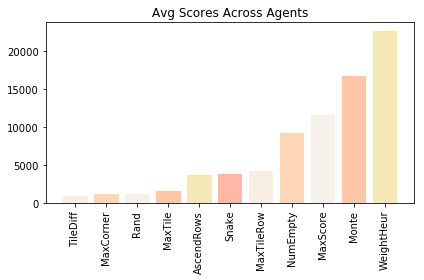

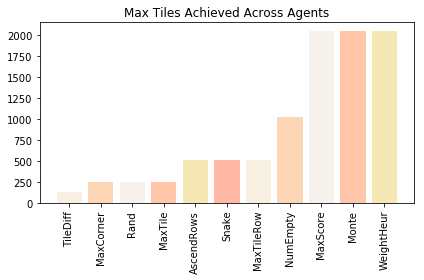

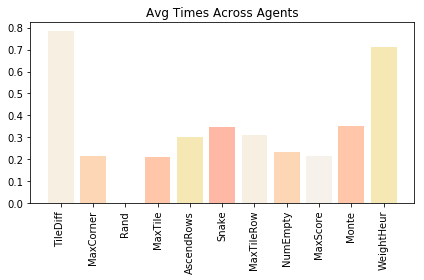

In [133]:
## Gets mean final score across all trials for particular agent's dataset
# and standard deviation across these trials' final scores
def get_score_summary(data):
    scores_list = []
    trials = np.unique(data["Trial"])
    for trial in trials:
        scores_list.append(data.loc[data["Trial"] == trial, :].tail(1)["Score"].iloc[0])
    return np.mean(scores_list), np.std(scores_list)

def get_avg_time(data):
    return data.mean()["Time"]

def get_max_tile(df):
    return max(df.loc[:, "Val0":"Val15"].max())

beige = "#EFE1C7"
orange = "#FDAF6F"
whiteish = "#F0E4D8"
dorange = "#FF8F57"
yellow = "#EFD26D"
red = "#FF704E"
background = "#BFAC9E"

colors = [beige, orange, whiteish, dorange, yellow, red]

data_rand = pd.read_csv(fname_rand)
data_max_score = pd.read_csv(fname_max_score) #
data_num_empt = pd.read_csv(fname_num_empt)
data_max_corner = pd.read_csv(fname_max_corner)
data_ascend_rows = pd.read_csv(fname_ascend_rows)
data_max_tile_row = pd.read_csv(fname_max_tile_row) #
data_weight_heur = pd.read_csv(fname_weight_heur) #
data_monte = pd.read_csv(fname_monte) #

data_snake = pd.read_csv(fname_snake) #
data_max_tile = pd.read_csv(fname_max_tile) #
data_tile_diff = pd.read_csv(fname_tile_diff) #

data_frame_lst = [
    data_tile_diff, data_max_corner, data_rand, data_max_tile, 
    data_ascend_rows, data_snake,  
    data_max_tile_row, data_num_empt, data_max_score, 
    data_monte, data_weight_heur, 
]

data_frame_labels = [
    "TileDiff", "MaxCorner", "Rand", "MaxTile", "AscendRows", "Snake", "MaxTileRow", 
    "NumEmpty", "MaxScore", "Monte", "WeightHeur"
]

max_tiles_lst = []
mean_scores_lst = []
mean_times_lst = []
for df in data_frame_lst:
    mean_time = get_avg_time(df)
    mean_times_lst.append(mean_time)
    
    mean_score, _sd = get_score_summary(df)
    mean_scores_lst.append(mean_score)
    
    max_tile = get_max_tile(df)
    max_tiles_lst.append(max_tile)

# Score histogram
col_cycle = cycle(colors)
x = range(len(mean_scores_lst))
plt.title("Avg Scores Across Agents")
plt.bar(x, mean_scores_lst, align = 'center', alpha = 0.5, 
        color = [next(col_cycle) for i in range(len(data_frame_lst))]
)
plt.xticks(
    x, data_frame_labels, 
    rotation = 90
)
plt.tight_layout()
plt.savefig("2048_avg_agent_score_barchart")
plt.show()

# Max Tiles histogram
col_cycle = cycle(colors)
x = range(len(max_tiles_lst))
plt.title("Max Tiles Achieved Across Agents")
plt.bar(x, max_tiles_lst, align = 'center', alpha = 0.5, 
        color = [next(col_cycle) for i in range(len(data_frame_lst))]
)
plt.xticks(
    x, data_frame_labels, 
    rotation = 90
)
plt.tight_layout()
plt.savefig("2048_max_tiles_barchart")
plt.show()

# Time histogram
col_cycle = cycle(colors)
x = range(len(mean_times_lst))
plt.title("Avg Times Across Agents")
plt.bar(x, mean_times_lst, align = 'center', alpha = 0.5, 
       color = [next(col_cycle) for i in range(len(data_frame_lst))]
)
plt.xticks(
    x, data_frame_labels, 
    rotation = 90
)
plt.tight_layout()
plt.savefig("2048_avg_agent_time_barchart")
plt.show()

# **Generate Heatmaps for All**

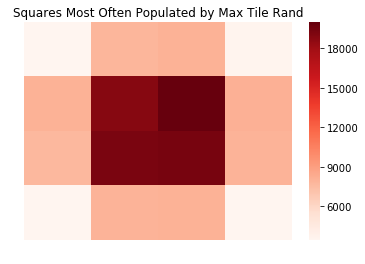

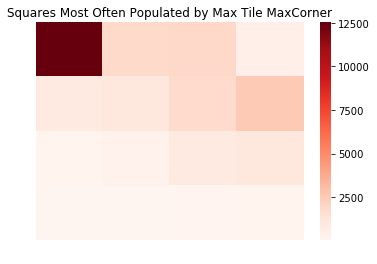

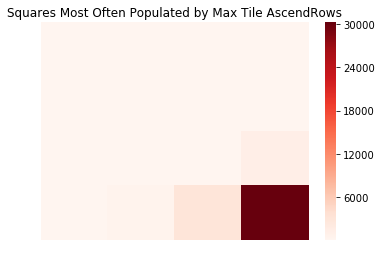

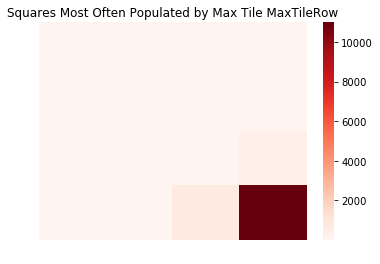

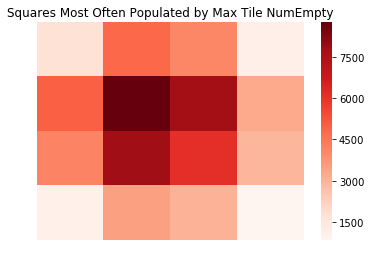

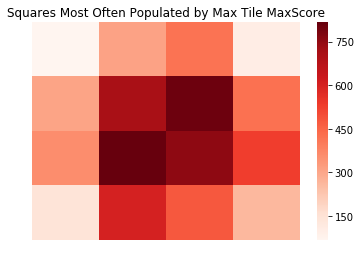

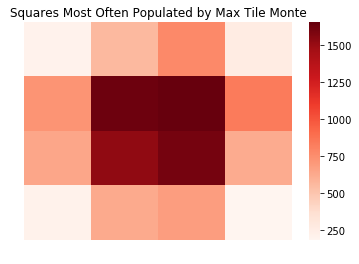

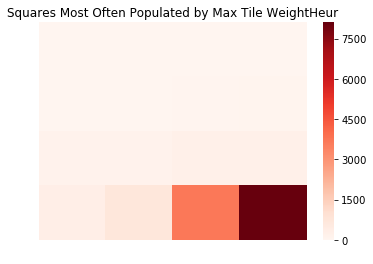

In [96]:
data_frame_lst = [
    data_rand, data_max_corner, data_ascend_rows, 
    data_max_tile_row, data_num_empt, data_max_score, 
    data_monte, data_weight_heur
]

data_frame_labels = [
    "Rand", "MaxCorner", "AscendRows", "MaxTileRow", 
    "NumEmpty", "MaxScore", "Monte", "WeightHeur"
]

for data, label in zip(data_frame_lst, data_frame_labels):
    #### HEATMAP TO OBSERVE MOST COMMON LOCATION OF MAXTILE ####
    tiles = data.loc[:, "Val0":"Val15"].copy()

    # True for entry within particular row if that entry contains max tile value
    # at that point in the game, otherwise false
    is_max_tile_each_row = tiles.apply(
        lambda row: row == data.loc[:, "Val0":"Val15"].max(axis = 1)
    )

    frequency_max_tile = np.array(is_max_tile_each_row.sum()).reshape((n, n))

    # annot = frequency_max_tile
    sns.heatmap(
        frequency_max_tile, 
        cmap = "Reds"
    )
    plt.title("Squares Most Often Populated by Max Tile " + label)
    plt.axis("off")
    plt.savefig("2048_max_tile_heatmap " + label)
    plt.show()

# Moves Required to Get to Each Tile

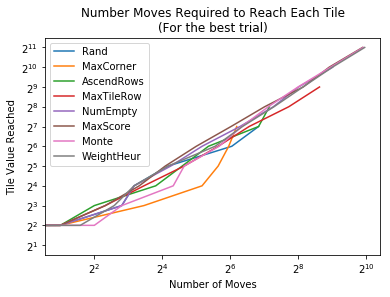

In [141]:
data_frame_lst = [
    data_rand, data_max_corner, data_ascend_rows, 
    data_max_tile_row, data_num_empt, data_max_score, 
    data_monte, data_weight_heur
]

data_frame_labels = [
    "Rand", "MaxCorner", "AscendRows", "MaxTileRow", 
    "NumEmpty", "MaxScore", "Monte", "WeightHeur"
]

for data, label in zip(data_frame_lst, data_frame_labels):
    tiles = data.loc[:, "Val0":"Val15"].copy()

    # Entry in this list is list of attained values over a particular trial
    # in ascending order
    unique_maxes_over_all_trials = []

    # Entry in this list is list of number of moves required to reach each
    # of the attained values in corresponding list in unique_maxes_over_all_trials
    num_moves_required_over_all_trials = []

    for trial in trials:
        # Subset data to relevant trial
        indices_of_trial = data["Trial"] == trial
        trial_tiles = tiles.loc[indices_of_trial].reset_index(drop = True)

        max_at_each_move = trial_tiles.max(axis = 1) 

        # The highest vals reached across entire trial
        unique_maxes = np.unique(max_at_each_move)
        unique_maxes_over_all_trials.append(list(unique_maxes))

        # Get index of first appearance of particular max tile
        # over course of a trial, corresponds to number of moves needed
        # to reach that tile
        num_moves_required = [max_at_each_move[max_at_each_move == tile].index[0] for tile in unique_maxes]
        num_moves_required_over_all_trials.append(num_moves_required)

    def return_longest_sublist(lst):
        return max(lst, key = len)

    best_trial_maxes = return_longest_sublist(unique_maxes_over_all_trials)
    best_trial_num_moves = return_longest_sublist(num_moves_required_over_all_trials)

    plt.plot(best_trial_num_moves, best_trial_maxes, label = label)
    plt.title("Number Moves Required to Reach Each Tile\n(For the best trial)")
    plt.yscale('log', basey = 2)
    plt.xscale('log', basex = 2)
    plt.xlabel("Number of Moves")
    plt.ylabel("Tile Value Reached")
    plt.yticks(best_trial_maxes)
    plt.grid(axis = 'y')
plt.legend()
plt.savefig("2048_num_moves_required_overall")
plt.show()